In [1175]:
import sys
import warnings

warnings.filterwarnings("ignore")
from itertools import product
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from statsmodels.tsa.holtwinters import Holt

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from plotly import __version__
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
pd.set_option("display.max_rows",500)

init_notebook_mode(connected=True)

In [1025]:
df = pd.read_csv("train-2.csv")
test_df = pd.read_csv(
    "test-2.csv", index_col=["Date"], parse_dates=["Date"]
)

In [1027]:
df

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-01-10,1453329.50,71.89,2.603,211.671989,7.838
1,1,2010-02-04,1594968.28,62.27,2.719,210.820450,7.808
2,1,2010-02-07,1492418.14,80.91,2.669,211.223533,7.787
3,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106
4,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106
...,...,...,...,...,...,...,...
6250,45,2012-09-14,702238.27,67.87,3.948,191.699850,8.684
6251,45,2012-09-21,723086.20,65.32,4.038,191.856704,8.684
6252,45,2012-09-28,713173.95,64.88,3.997,192.013558,8.684
6253,45,2012-10-02,803657.12,37.00,3.640,189.707605,8.424


In [1029]:
df
df = df.set_index(["Date"])
target = df["Weekly_Sales"]
columns = df.columns.drop("Weekly_Sales").drop("Store")
columns

Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], dtype='object')

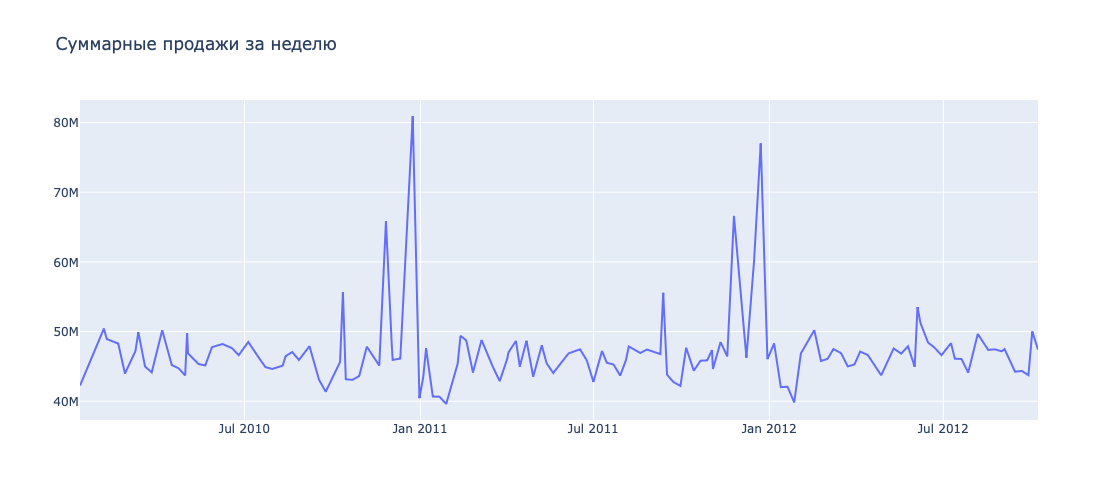

In [1031]:
go.Figure(
    go.Scatter(
        x=df.index,
        y=df.groupby(df.index).agg('sum')['Weekly_Sales'],
    ),
    layout=dict(
        title='Суммарные продажи за неделю',
        width=1000,
        height=500,
    )
).show()

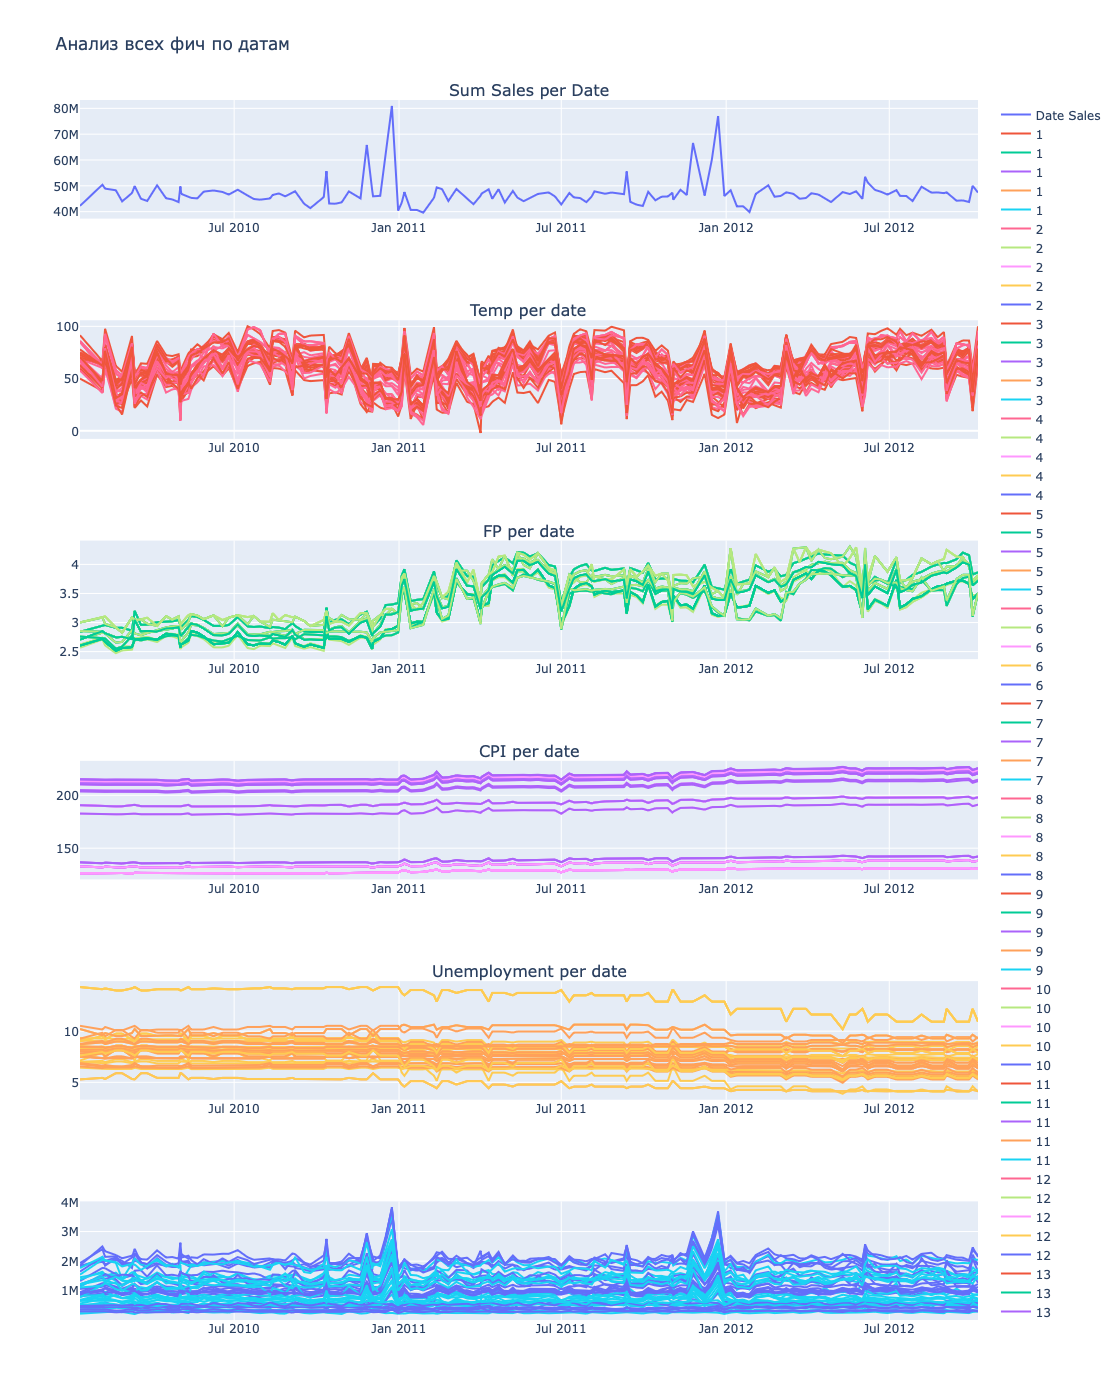

In [1033]:
fig = make_subplots(rows=6, cols=1, subplot_titles=("Sum Sales per Date", "Temp per date", "FP per date", "CPI per date", "Unemployment per date"))

store_per_date = { store: data for store, data in df.groupby('Store') }
    
#fig.add_trace(go.Scatter(x=target, y=df[columns[0]], name=columns[0]), row=1, col=1)
#fig.add_trace(go.Scatter(x=target, y=df[columns[1]], name=columns[1]), row=1, col=2)
#fig.add_trace(go.Scatter(x=target, y=df[columns[2]], name=columns[2]), row=2, col=1)
#fig.add_trace(go.Scatter(x=target, y=df[columns[3]], name=columns[3]), row=2, col=2)

#fig.update_layout(title_text="Много графиков в одном большом")

# Отображение
#fig.show()
fig.add_trace(go.Scatter(x=df.index,y=df.groupby(df.index).agg('sum')['Weekly_Sales'], name="Date Sales"), row=1,col=1)
for store,date in store_per_date.items():
    fig.add_trace(go.Scatter(x=date.index, y=date[columns[0]], name=store), row=2, col=1)
    fig.add_trace(go.Scatter(x=date.index, y=date[columns[1]], name=store), row=3, col=1)
    fig.add_trace(go.Scatter(x=date.index, y=date[columns[2]], name=store), row=4, col=1)
    fig.add_trace(go.Scatter(x=date.index, y=date[columns[3]], name=store), row=5, col=1)
    fig.add_trace(go.Scatter(x=date.index, y=date["Weekly_Sales"], name=store), row=6, col=1)

    
    fig.update_layout(title_text="Анализ всех фич по датам",height=1400,  # Увеличение высоты (в пикселях)
    width=1200,   # Увеличение ширины (в пикселях)
    showlegend=True  # Отображение легенды)
                     )

# Отображение
fig.show()

In [1034]:

store = df.groupby("Store").agg("sum")["Weekly_Sales"].to_dict()
print(min(store.items(),key=lambda x:x[1]))
print(max(store.items(), key=lambda x:x[1]))

df.index = pd.to_datetime(df.index)

stores = df["Store"].unique()

# for store in stores:
#     store_date = df[df["Store"]==store]

#     # Создадим новую колонку с понедельными интервалами, просто меняя даты на последовательные понедельники
#     start_date = df.index.min()  # Первая дата
#     week_start_dates = pd.date_range(start=start_date, periods=len(store_date), freq='W-SUN')  # Генерируем понедельники
    
#     # Присваиваем новые даты
#     df.loc[df["Store"] == store, "NewDate"] = week_start_dates
# df = df.set_index(["NewDate"])
# df.head(200)


    

(33, 36064455.5)
(20, 293035729.95)


### Анализируя графики какой то закономерности в связи фич я не нашел, кроме того что пики у нас наблюдаются в периоды черной пятницы, нового года. Короче для начала сделаем Sarimax

In [35]:
stores = df["Store"].unique()
forecast_results = []
counter = 1
ID = 0
for store in stores:
    # Фильтруем данные по магазину
    store_data = df[df['Store'] == store]
    store_sales = store_data['Weekly_Sales']
    
    # Шаг 1: Подбор параметров SARIMAX с auto_arima
    stepwise_fit = auto_arima(store_sales, max_p=2,  # Уменьшение максимального значения p
    max_q=2,  # Уменьшение максимального значения q
    max_P=2,  # Уменьшение сезонного P
    max_Q=2 ,
    seasonal=True, m=52, suppress_warnings=True,stepwise=True,max_order=5,trace=True)
    order = stepwise_fit.order
    seasonal_order = stepwise_fit.seasonal_order
    
    # Шаг 2: Обучение модели SARIMAX
    model = SARIMAX(store_sales, order=order, seasonal_order=seasonal_order)
    fitted_model = model.fit(disp=False)
    
    forecast_steps = 4
    last_date = store_sales.index[-1]
    print(f"Store - {counter}")
    forecast_index = pd.date_range(last_date, periods=forecast_steps, freq='W')
    forecast = fitted_model.get_forecast(steps=forecast_steps)
    forecast_values = forecast.predicted_mean.values
    
    forecast_results.append(forecast_values)
    ID+=1
    counter += 1

    

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=3.12 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3762.474, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3748.758, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3760.482, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=3754.603, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=3747.889, Time=1.88 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=3749.889, Time=3.62 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=3756.348, Time=1.48 sec
 ARIMA(2,1,0)(2,0,0)[52] intercept   : AIC=3734.687, Time=2.30 sec
 ARIMA(2,1,0)(1,0,0)[52] intercept   : AIC=3734.841, Time=0.47 sec
 ARIMA(2,1,0)(2,0,1)[52] intercept   : AIC=3736.687, Time=8.37 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=3734.797, Time=0.92 sec
 ARIMA(2,1,1)(2,0,0)[52] intercept

In [37]:
sub_temp = np.concatenate(forecast_results)
submit = pd.DataFrame(sub_temp, columns=["Weekly_Sales"])
submit["ID"] = submit.index
submit = submit[["ID","Weekly_Sales"]]
submit = submit.reset_index(drop=True)
submit.to_csv('submission.csv', index=False)
submit.head(180)

,ID,Weekly_Sales
0,0,1.584090e+06
1,1,1.564216e+06
2,2,1.582406e+06
3,3,1.565570e+06
4,4,1.948693e+06
5,5,1.857853e+06
6,6,1.878205e+06
7,7,1.814541e+06
8,8,4.282259e+05
9,9,4.107419e+05


### Цифры не впечатлили особо(0.11265), так что попробуем обучить линейнку 

In [1316]:
def prepareData(df,lag_start = 1, lag_end = 30,lag_mean = 10, test_size = 0.2):
    data = pd.DataFrame.copy(df)
    test_index = int(len(data) * (1 - test_size))
    #df["Mean_WK"] = df["Weekly_Sales"].mean()
    #df["Median_WK"] = df["Weekly_Sales"].median()
    for i in range(lag_start,lag_end):
        data[f"lag-{i}"] = data["Weekly_Sales"].shift(i)
        
        
    # holt_model = Holt(data['Weekly_Sales']).fit(smoothing_level=0.8, smoothing_slope=0.2)

    # Получаем сглаженные значения для уровня и тренда
    # data['Holt_Forecast'] = holt_model.fittedvalues
    # Уровень и тренд можно взять из параметров модели
    # data['Holt_Level'] = holt_model.level  # Уровень (состояние на последнем шаге)
    # data['Holt_Trend'] = holt_model.trend  # Тренд (состояние тренда на последнем шаге)

    # Holt модель не имеет 'slope' как атрибут, но можно использовать компонент тренда
    #data["hour"] = data.index.hour
    #data["month"] = data.index.month
    data["weekday"] = data.index.weekday
    data["is_weekend"] = data.weekday.isin([5, 6]) * 1
    #data['day_of_week'] = data.index.dayofweek
    #data["is_winter_month"] = data.index.month.isin([9,10,11]) * 1
    data["is_summer_month"] = data.index.month.isin([6,7,8]) * 1
    #data['year'] = data.index.year
    #data['season'] = data.index.month % 12 // 3 + 1
    data['rolling_mean'] = data['Weekly_Sales'].rolling(window=lag_mean, min_periods=1).mean()
    alpha = 0.2
    data['EMA'] = data['Weekly_Sales'].ewm(alpha=alpha, adjust=False).mean()
    #data['fuel_CPI_interaction'] = data['Fuel_Price'] * data['CPI']
    #data['temp_fuel_interaction'] = data['Temperature'] * data['Fuel_Price']

    data = data.fillna(data["lag-1"].mean())
    #data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(columns="Fuel_Price")
    
    X_train = data.loc[:test_index].drop(["Weekly_Sales"], axis=1)
    Y_train = data.loc[:test_index]["Weekly_Sales"]
    x_test = data.loc[test_index:].drop(["Weekly_Sales"], axis=1)
    y_test = data.loc[test_index:]["Weekly_Sales"]
    # print(data)
    data.drop(columns="Weekly_Sales",inplace=True)
    return data
    

In [1304]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet

X_train, x_test, Y_train, y_test = prepareData(
    df, test_size=0.2, lag_start=1, lag_end=12
)
lr = Ridge()
lr.fit(X_train, Y_train)
prediction = lr.predict(x_test)
print(mean_absolute_percentage_error(prediction,y_test))
#X_train

0.02870456562677385


In [1306]:
mape = []
models = []
counter = 1

for store in stores:
    store_date = df[df["Store"]==store]
    X_train, x_test, Y_train, y_test = prepareData(
    store_date, test_size=0.2, lag_start=1, lag_end=12,
    )
    pipeline = Pipeline([
        ('ridge', Ridge())  
    ])
    
    param_grid = {
        'ridge__alpha': [0.001,0.01,0.1,1,2,3,4,5,10,20,100,200,300,400,500,600,700]
    }
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_percentage_error')
    
    grid_search.fit(X_train, Y_train)
    # print(f"--------------------{counter}")
    # print("Лучшие параметры: ", grid_search.best_params_)
    # print("Лучший MAPE на тренировочных данных: %.6f"%-grid_search.best_score_)
    
    y_pred = grid_search.best_estimator_.predict(x_test)
    mape.append(mean_absolute_percentage_error(y_pred,y_test))
    models.append(grid_search.best_estimator_)
    counter+=1

print("MAPE - ",sum(mape)/len(mape))
best = 8.397908735182496e-11

MAPE -  0.017721947794698493


In [1308]:
tester = pd.concat([df,test_df],axis=0)
tester = tester.reset_index()
all_date = pd.DataFrame()
for store in stores:
    d = tester[tester["Store"]==store]
    d = d.sort_values(by=["Date"])
    all_date = pd.concat([all_date,d])
# tester.tail(200)
all_date.sort_values(by=["Store"])
all_date.set_index(["Date"],inplace=True)
all_date.head(143)

,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010-01-10,1,1453329.50,71.89,2.603,211.671989,7.838
2010-02-04,1,1594968.28,62.27,2.719,210.820450,7.808
2010-02-07,1,1492418.14,80.91,2.669,211.223533,7.787
2010-02-19,1,1611968.17,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,46.63,2.561,211.319643,8.106
2010-03-09,1,1540163.53,81.21,2.577,211.531248,7.787
2010-03-12,1,1548033.78,49.27,2.708,211.607193,7.838
2010-03-19,1,1472515.79,54.58,2.720,211.215635,8.106
2010-03-26,1,1404429.92,51.45,2.732,211.018042,8.106


### Линейка показала лучший результат 0.06665, попробуем скрестить arima и линейку взяв среднее от них

In [476]:
sub_temp_lin = np.concatenate(predicts)
sub_temp_arima = np.concatenate(forecast_results)
submit_1 = pd.DataFrame(sub_temp_lin, columns=["Weekly_Sales_1"])
submit_2 = pd.DataFrame(sub_temp_arima, columns=["Weekly_Sales_2"])
submit = pd.concat([submit_1,submit_2],axis=1)
submit["Weekly_Sales"] = (submit["Weekly_Sales_1"]+submit["Weekly_Sales_2"]+submit["Weekly_Sales_1"])/4
submit = submit.drop(columns="Weekly_Sales_1").drop(columns="Weekly_Sales_2")
submit["ID"] = submit.index
submit = submit[["ID","Weekly_Sales"]]
submit = submit.reset_index(drop=True)
submit.to_csv('submission.csv', index=False)
submit 

,ID,Weekly_Sales
0,0,1.516605e+06
1,1,1.511310e+06
2,2,1.616103e+06
3,3,1.620343e+06
4,4,1.863808e+06
5,5,1.841970e+06
6,6,1.865371e+06
7,7,1.877823e+06
8,8,4.595430e+05
9,9,4.549080e+05


## Среднее с удвоенной линейкой и arima((2*lin+arima)/2) показывает лучший результат = 0.06650

### Посмотрим 35 магазин потому что, линейная показывает на нем худший результат 

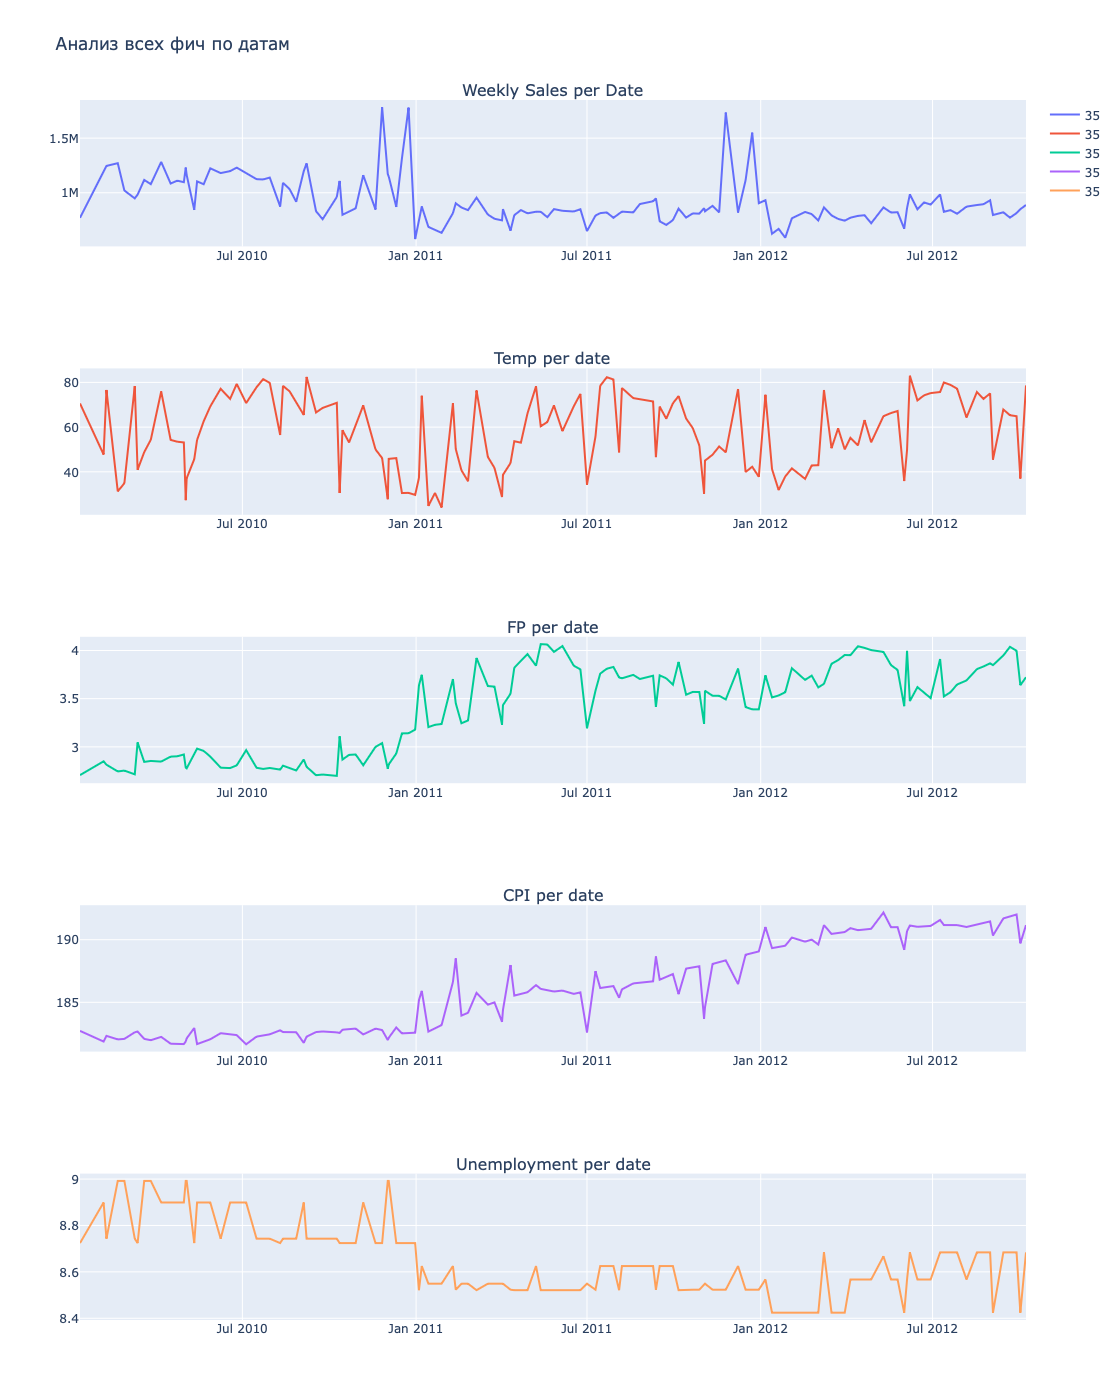

In [923]:
fig = make_subplots(rows=5, cols=1, subplot_titles=("Weekly Sales per Date", "Temp per date", "FP per date", "CPI per date", "Unemployment per date"))

df = df[df["Store"]==35]
    
#fig.add_trace(go.Scatter(x=target, y=df[columns[0]], name=columns[0]), row=1, col=1)
#fig.add_trace(go.Scatter(x=target, y=df[columns[1]], name=columns[1]), row=1, col=2)
#fig.add_trace(go.Scatter(x=target, y=df[columns[2]], name=columns[2]), row=2, col=1)
#fig.add_trace(go.Scatter(x=target, y=df[columns[3]], name=columns[3]), row=2, col=2)

#fig.update_layout(title_text="Много графиков в одном большом")

# Отображение
#fig.show()
fig.add_trace(go.Scatter(x=df.index, y=df["Weekly_Sales"], name=35), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=date["Temperature"], name=35), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=date["Fuel_Price"], name=35), row=3, col=1)
fig.add_trace(go.Scatter(x=df.index, y=date["CPI"], name=35), row=4, col=1)
fig.add_trace(go.Scatter(x=df.index, y=date["Unemployment"], name=35), row=5, col=1)

    
fig.update_layout(title_text="Анализ всех фич по датам",height=1400,  # Увеличение высоты (в пикселях)
width=1200,   # Увеличение ширины (в пикселях)
showlegend=True  # Отображение легенды)
                 )

# Отображение
fig.show()

In [1318]:
predicts = []
def predict_fin_submit(df,stores):
    for store in stores:
        store_date = df[df["Store"]==store]
        x_test = prepareData(
    store_date, test_size=0, lag_start=1, lag_end=12,
    )
        # print(x_test)
        # print(x_test.shape[0])
        for i in range(x_test.shape[0]-4,x_test.shape[0]):
            row_as_df = x_test.iloc[[i], :]  
            # print(models[store-1].predict(row_as_df))
            store_date.iloc[i,store_date.columns.get_loc("Weekly_Sales")] = models[store-1].predict(row_as_df)[0]
            predicts.append(store_date.iloc[i][store_date.columns.get_loc("Weekly_Sales")])
            x_test = prepareData(
            store_date, test_size=0, lag_start=1, lag_end=12,
            )
            # print(1)
predict_fin_submit(all_date,stores)
len(predicts)
    

180

### BEST = 0.04174

In [1321]:

submit = pd.DataFrame(predicts,columns=["Weekly_Sales"])
submit["ID"] = submit.index
submit = submit[["ID","Weekly_Sales"]]
submit = submit.reset_index(drop=True)
submit.to_csv('submission.csv', index=False)
submit 

,ID,Weekly_Sales
0,0,1.572854e+06
1,1,1.562760e+06
2,2,1.572550e+06
3,3,1.565058e+06
4,4,1.881977e+06
5,5,1.873291e+06
6,6,1.874352e+06
7,7,1.872151e+06
8,8,4.155426e+05
9,9,4.172519e+05


In [1229]:
predicts_2 = []
def predict_fin_submit_2(df,stores):
    for store in stores:
        store_date = df[df["Store"]==store]
        x_test = prepareData(
    store_date, test_size=0, lag_start=1, lag_end=10,
    )
        # print(x_test.shape[0])
        for i in range(x_test.shape[0]-4,x_test.shape[0]):
            row_as_df = x_test.iloc[[i], :]  
            store_date.iloc[i,store_date.columns.get_loc("Weekly_Sales")] = models[store-1].predict(row_as_df)[0]
            predicts_2.append(store_date.iloc[i][store_date.columns.get_loc("Weekly_Sales")])
predict_fin_submit_2(all_date,stores)
submit = pd.DataFrame(predicts_2,columns=["Weekly_Sales"])
submit["ID"] = submit.index
submit = submit[["ID","Weekly_Sales"]]
submit = submit.reset_index(drop=True)
submit.to_csv('submission.csv', index=False)
submit 

,ID,Weekly_Sales
0,0,1.535332e+06
1,1,1.555517e+06
2,2,1.555517e+06
3,3,1.555517e+06
4,4,1.931785e+06
5,5,1.927207e+06
6,6,1.927207e+06
7,7,1.927207e+06
8,8,4.019594e+05
9,9,4.022590e+05
